# Custom Photon Fields

## Introduction

To fully integrate custom photon fields into a CRPropa simulation **two** photon field classes for each photon field model have to be generated. This comes from the separation of the generation of tabulated data, e.g. interaction rates, of the actual propagation code. 

All tabulated files are precalculated with tools in the CRPropa-data repository (https://github.com/CRPropa/CRPropa3-data). Usually, the resulting data files are downloaded and moved to the correct location during the install process of CRPropa. For custom photon fields all relevant files have to be generated and copied to the correct location manually. Here, the first photon field class---inhereting from a base class in CRPropa-data---is used.

In addition to all precalculated data files, CRPropa needs more functionality for photon targets. This is implemented by the implementation of the second photon field class---this time inhereting from a CRPropa module.

### Downloading CRPropa-data
The easiest way to get the relevant files is to download/clone the full repository. 

    git clone https://github.com/CRPropa/CRPropa3-data.git

### 1. Create a python class with your custom photon field (CRPropa-data)
In this example we show the production of a custom photon field for two different cases. 
First we consider a photon field where the spectral number density is given by an analytical expression. We consider a powerlaw with a given slope  $\alpha = -2.75$ in a maximal energy range $[E_\mathrm{min} = 10^{-3}\,\mathrm{eV}, E_\mathrm{max} = 1\,\mathrm{eV}]$. 

The second example is based on a tabulated data file. Here, we use the ISRF model R12 presented in Porter, Johannesson, and Moskalenko, ApJ 846, 67 (2017), which can be downloaded from the GALPROP website: https://galprop.stanford.edu/download.php and is included in the crpropa installation. As CRPropa allows only for isotropic and homogeneous photon fields we use the field at position $(X = 0.0173648 \, \mathrm{kpc}, Y = 0.0984808 \, \mathrm{kpc})$.


All photon fields must have the following mandatory parameters and functions:
- name  (string):   name of the photon field, needed for the naming of the files
- info  (string):   information tag used for the comments at the beginning of the file
- redshift  (None/Array):     Determines if the photon field is redshift dependent. If None no redshift dependence is given. Otherwise the (tabulated) redshift must be provided as a 1D array
- energy (Array):   Energies used to calculate files in data/Scaling (must be given in [$\mathrm{eV}$]).
- photonDensity (Array):    Spectral energy density used to calculate files in data/Scaling (must be given in [$\mathrm{eV}^{-1}\,\mathrm{ccm}^{-1}$]).
- getDensity    (function):     returns the spectral number density dn/deps(eps, z) at a given photon energy (eps) and redshift (z)
- getEmin   (function):     returns the minimum effective photon energy
- getEmax   (function):     returns the maximum effective photon energy


### Warning
Note that CRPropa and CRPropa-Data are currently using different conventions for units of length and energy. CRPropa's default unit system is in SI units so length is in *meter* and energy is alsways in *joule*. The units in CRPropa-Data are not yet consistently converted to SI units. Therefore, the user has to pay attention to define the photon field class parameters with the correct units; see above and in the example class definition below.

In [1]:
import numpy as np
import pandas as pd 
from scipy.interpolate import interp1d
import warnings
import os
import sys
import crpropa as crp
from crpropa import eV, ccm, c_light, h_planck
import subprocess


#Change for path to the CRPropa data repository
crpropa_data_path = "/rest/CRPropa3-data/"
sys.path.append(crpropa_data_path)

crpropa_share_path = "/rest/venvs/crp_docu/share/crpropa/"

import photonField as pf
import calc_all as ca

import matplotlib.pyplot as plt # optional for plotting

In [3]:
class PowerlawPhotonField(pf.PhotonField):    

    def __init__(self, norm = 1e20, slope = -2.75, eMin = 1e-3 * eV, eMax = 1 * eV):
        """
            Initialize the photon field as a powerlaw with exponential cutoffs at both ends. 
            The slope, the normalization (n(eps = 1 eV)) and the minimal and maximal energy can be modified. 
        """
        super(PowerlawPhotonField, self).__init__()
        self.name = "PowerlawPhotonField"
        self.info = "Single power law photon field with exponential cutoffs at both ends."
        self.redshift = None
        self.norm = norm
        self.slope = slope
        self.eMin = eMin
        self.eMax = eMax
        self.energy = np.logspace(np.log10(self.eMin),np.log10(self.eMax), 101) / eV
        self.photonDensity = self.getDensity(self.energy * eV) / (eV**-1 * ccm**-1)
    
    def getDensity(self, eps, z = 0):
        """
            Comoving spectral number density dn/deps [1/m^3/J] at given photon energy eps [J] and redshift z.
            Multiply with (1+z)^3 for the physical number density.
        """
        # array handling
        if (type(eps) == np.ndarray):
            return np.array([self.getDensity(_eps, z) for _eps in eps])
        if (eps >= self.eMin) & (eps <= self.eMax):
            return self.norm * (eps / eV)**self.slope
        else:
            return 0.
 
    def getEmin(self):
        """Minimum effective photon energy in [J]"""
        return self.eMin
    
    def getEmax(self):
        """Maximum effective photon energy in [J]"""
        return self.eMax


class ISRF(pf.PhotonField):    

    def __init__(self, dataPath = crpropa_data_path+"data/CustomPhotonField/isrf_example_field.dat"):
        super(ISRF, self).__init__()
        self.name = "ISRF"
        self.info = "Inter Stellar Radiation Field. Model F98 from Porter+(2017)"
        self.redshift = None
        names = ["micron", "total", "direct", "scattered", "transient", "thermal"]
        df = pd.read_csv(dataPath, delimiter=" ", names = names)
        df["E"] = h_planck * c_light / (df.micron * 1e-6)
        df["n"] = df.total *(eV / ccm) / df.E**2
        self.data = df[df.total>1e-25] # limit nan-values 
        self.eMin = self.data["E"].min()
        self.eMax = self.data["E"].max()

        self.energy = df["E"] / eV
        self.photonDensity = df["n"] / (eV**-1 * ccm**-1)

    def getDensity(self, eps, z = 0):
        """
            Comoving spectral number density dn/deps [1/m^3/J] at given photon energy eps [J] and redshift z.
            Multiply with (1+z)^3 for the physical number density.
        """

        f = interp1d(self.data["E"], self.data["n"], bounds_error=False, fill_value=0)
        return f(eps)
 
    def getEmin(self):
        """Minimum effective photon energy in [J]"""
        return self.eMin
    
    def getEmax(self):
        """Maximum effective photon energy in [J]"""
        return self.eMax
    

field = PowerlawPhotonField()
isrf = ISRF()

#### Plotting (Optional)
Here, both custom photon fields are plotted. Additionaly, the already implemented cosmic microwave background is plotted for comparison.

/rest/CRPropa3-data/photonField.py:79: RuntimeWarning: overflow encountered in expm1
  return 8*np.pi / c_light**3 / h_planck**3 * eps**2 / np.expm1(eps / (k_boltzmann * self.T_CMB))


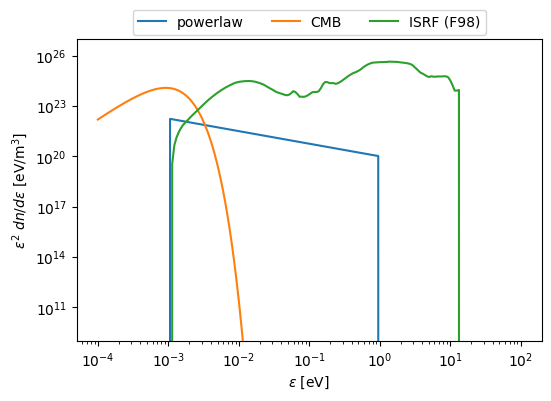

In [4]:
field_cmb = pf.CMB()

eps = np.logspace(-4, 2, 200) * eV
c = eps**2 / eV**2
plt.figure(dpi = 100)
y1 = c * field.getDensity(eps)
y2 = c * field_cmb.getDensity(eps)
y3 = c * isrf.getDensity(eps)
plt.plot(eps / eV, y1, label = "powerlaw")
plt.plot(eps / eV, y2, label = "CMB") 
plt.plot(eps / eV, y3, label = "ISRF (F98)")

plt.loglog()
plt.legend(ncol = 3, loc= "upper center", bbox_to_anchor=(0.5, 1.12))
plt.ylim([1e9, 1e27])

plt.xlabel("$\epsilon$ [eV]")
plt.ylabel("$\epsilon^2 ~ dn/d\epsilon$ [eV/m$^3$]")
plt.show()

### 2. Create tables for all photon field dependent processes 

Here, tables for all CRPropa interactions are calculated. This process takes some time (~15 minutes).

In [5]:
with warnings.catch_warnings(): # catch warnings from where density is approx 0 -> leads to division by zero errors
    warnings.simplefilter("ignore")
    ca.createPhotonTargetInteractions([field, isrf])

##################################################
Calculate elastic scattering.

PowerlawPhotonField
ISRF

Elastic scattering tables generated in 15.22 seconds.
##################################################

##################################################
Calculate electromagnetic processes:
	- Pair production
	- Double pair production
	- Triple pair production
	- Inverse Compton scattering
PowerlawPhotonField
ISRF

Electromagnetic processes generated in 127.21 seconds.
##################################################

##################################################
Calculate Bethe-Heitler pair production.

PowerlawPhotonField
ISRF

BH pair production tables generated in 24.3 seconds.
##################################################

##################################################
Calculate photo disintegration.

PowerlawPhotonField
ISRF
PowerlawPhotonField
ISRF

Photo disintegration tables generated in 640.97 seconds.
################################################

### 3. Copy files to the share folder
The files stored in "CRPropa3-data/data" must be copied in the share folder of the CRPropa installation. 

In [6]:
subprocess.run(['cp', '-a', './data/.', crpropa_share_path])

CompletedProcess(args=['cp', '-a', './data/.', '/rest/venvs/crp_docu/share/crpropa/'], returncode=0)

### 4. Implementing custom PhotonField in CRPropa
To fully implement a custom model in a CRPropa simulation an additional class definition---this time inhereting from CRPropa's *PhotonField* class---is needed. Two different implementations are needed for the power-law and interstellar radiation field, since the latter one must be implemented as a so called *TabularPhotonField*. The power-law photon field is realised with a simple python class:

In [7]:
class CustomPhotonField(crp.PhotonField):
    """Analogue implementation like above but inheriting from the CRPropa module for compatibility"""

    def __init__(self, name, norm = 1e20, slope = -2.75, eMin = 1e-3 * eV, eMax = 1 * eV):
        crp.PhotonField.__init__(self)
        self.setFieldName(name)
        self.norm = norm
        self.slope = slope
        self.eMin = eMin
        self.eMax = eMax

    def getPhotnDensity(self, eps, z = 0.):
        return self.norm * (eps / eV)**self.slope * np.exp(- eps / self.eMax - self.eMin / eps)
    
    
    def getMinimumPhotonEnergy(self, z = 0):
        return self.eMin
    
    def getMaximumPhotonEnergy(self, z = 0):
        return self.eMax   

powerlaw_field = CustomPhotonField("PowerlawPhotonField")

The implementation for the interstellar radiation field is even easier as a base class for the tabular photon field exists:

In [8]:
isrf_field = crp.TabularPhotonField("ISRF", False)

### 5. Check implementation
To check the new photon fields all interactions depending on photon target are added to a *ModuleList*. If the installation was done correctly this should run without any error meaning all interaction can be used.  

In [9]:
sim = crp.ModuleList()

sim.add(crp.ElasticScattering(powerlaw_field))
sim.add(crp.ElasticScattering(isrf_field))


sim.add(crp.EMPairProduction(powerlaw_field))
sim.add(crp.EMPairProduction(isrf_field))

sim.add(crp.EMDoublePairProduction(powerlaw_field))
sim.add(crp.EMDoublePairProduction(isrf_field))

sim.add(crp.EMTripletPairProduction(powerlaw_field))
sim.add(crp.EMTripletPairProduction(isrf_field))

sim.add(crp.EMInverseComptonScattering(powerlaw_field))
sim.add(crp.EMInverseComptonScattering(isrf_field))

sim.add(crp.PhotoDisintegration(powerlaw_field))
sim.add(crp.PhotoDisintegration(isrf_field))

sim.add(crp.PhotoPionProduction(powerlaw_field))
sim.add(crp.PhotoPionProduction(isrf_field))

sim.add(crp.ElectronPairProduction(powerlaw_field))
sim.add(crp.ElectronPairProduction(isrf_field))

print("Everything works fine")

Everything works fine


In [10]:
crpCMB = crp.CMB() #T_CMB = 2.73 --> Leading to small differences 
crpCMB2 = crp.BlackbodyPhotonField("CMBTest", 2.72548)

In [11]:
print( crpCMB.getFieldName())
print( crpCMB.getMaximumPhotonEnergy(0))
print( crpCMB.getMinimumPhotonEnergy(0))
print( crpCMB.getPhotonDensity(1e-3*eV, 0))
print( crpCMB.getRedshiftScaling(1))

CMB
1.6021764870000002e-20
4.783281527694803e-24
190679052.33698764
1.0


In [12]:
print( crpCMB2.getFieldName())
print( crpCMB2.getMaximumPhotonEnergy(0))
print( crpCMB2.getMinimumPhotonEnergy(0))
print( crpCMB2.getPhotonDensity(1e-3*eV, 0))
print( crpCMB2.getRedshiftScaling(1))


CMBTest
1.6021764870000002e-20
4.775361955348583e-24
189320351.79205775
1.0


In [13]:
print( field_cmb.name)
print( field_cmb.getEmax(0))
print( field_cmb.getEmin(0))
print( field_cmb.getDensity(1e-3*eV, 0)*eV*1e-3)

CMB
1.6021764870000002e-20
1.602176487e-29
189320351.79205772


### 6. Limitation
For Bethe-Heitler pair production (*ElectronPairProduction*) secondary electrons cannot be injected into the simulation chain. This is due to a lack in the production of the needed tabulated data files. If you want to help to improve CRPropa take a look at the corresponding file (calc_pairproduction.py) in the CRPropa3-data repository (https://github.com/CRPropa/CRPropa3-data.git) and open a pull request.

In [14]:
crp.ElectronPairProduction(powerlaw_field, True)

RuntimeError: ElectronPairProduction: could not open file /rest/venvs/crp_docu/share/crpropa/ElectronPairProduction/spectrum_Pow.txt